[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ryanfobel/gridwatch-history/setup-binder-link)

In [7]:
%load_ext autoreload
%autoreload 2

import os
import sys

sys.path.insert(0, ".")

# Plotting preferences
from matplotlib import rcParams

rcParams.update({"figure.figsize": (12, 6)})
bin_width = 0.9
alpha = 0.5
transparent = False
bbox_inches = "tight"
facecolor = "white"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import datetime as dt
from typing import List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arrow

# Download CARMA database here: https://www.cgdev.org/sites/default/files/CARMAv30_PowerUser.zip


def extract_datetime_from_string_list(str_list: List[str]) -> pd.Series:
    # Example of the string index: 'Thu Oct 14, 8 AM - 9 AM'
    df = pd.Series(str_list).str.extract(
        r'(?P<dow>[a-zA-Z]{3}) '
        r'(?P<month>[a-zA-Z]{3}) '
        r'(?P<day>\d+), '
        r'(?P<start_hour>\d+) '
        r'(?P<start_AMPM>[A-Z]{2}) - '
        r'(?P<end_hour>\d+) '
        r'(?P<end_AMPM>[A-Z]{2})'
    )
    # convert types
    df = df.dropna()
    df["start_hour"] = df["start_hour"].astype(int)
    df["end_hour"] = df["end_hour"].astype(int)

    # Convert 3-letter month into number
    months = list(set(df["month"].values))
    month_letters_to_number = dict(zip(months, [dt.datetime.strptime(mon, '%b').month for mon in months]))
    df["month"] = df["month"].map(month_letters_to_number)

    df = df.drop(columns=["dow"]).dropna().copy()

    # Find the indices where the months and years "rollover"
    month_rollover_index = df[:-1][
        df.loc[df.index[1:], "month"].values !=
        df.loc[df.index[:-1], "month"].values
    ].index

    year_rollover_index = df.loc[month_rollover_index[:-1]][
        df.loc[month_rollover_index[1:], "month"].values <
        df.loc[month_rollover_index[:-1], "month"].values
    ].index

    # Assume the most recent date is from the current year
    end_year = dt.datetime.now().year
    df["year"] = end_year

    for index in reversed(year_rollover_index):
        df.loc[:index, "year"] = df.loc[:index, "year"] - 1

    # Convert to 24hr time
    start_hour_lt_12_and_PM_index = df[(df["start_hour"] < 12) & (df["start_AMPM"] == "PM")].index
    df.loc[start_hour_lt_12_and_PM_index, "start_hour"] = df.loc[start_hour_lt_12_and_PM_index, "start_hour"] + 12
    start_hour_12_and_AM_index = df[(df["start_hour"] == 12) & (df["start_AMPM"] == "AM")].index
    df.loc[start_hour_12_and_AM_index, "start_hour"] = 0

    # Drop extra columns
    df = df.drop(columns={"end_AMPM", "start_AMPM", "end_hour"})
    df = df.rename(columns={"start_hour": "hour"})
    df["dt"] = pd.to_datetime(df)

    hr_23_index = df[df["hour"] == 23].index
    df.loc[hr_23_index, "dt"] = df.loc[hr_23_index, "dt"] - pd.Timedelta(1, "d")

    return df["dt"]


In [3]:
def cleanup(df: pd.DataFrame):
    df = df.copy()
    dt_index = extract_datetime_from_string_list(df.index)
    df = df.reset_index().loc[dt_index.index]
    df.index = dt_index.values
    df = df.drop(columns="index")
    return df

df_capability = pd.read_csv("../data/capability.csv", thousands=',')
df_plants = pd.read_csv("../data/plants.csv")
df_output = pd.read_csv("../data/output.csv", index_col=0, thousands=',')
df_summary = cleanup(pd.read_csv("../data/summary.csv", index_col=0, thousands=','))

df_summary.head()

,imports,exports,netImportExports,POWER GENERATED,ONTARIO DEMAND,TOTAL EMISSIONS,CO2e INTENSITY,nuclearPercentage,hydroPercentage,gasPercentage,windPercentage,biofuelPercentage,solarPercentage,nuclearOutput,hydroOutput,gasOutput,windOutput,biofuelOutput,solarOutput
2021-10-14 08:00:00,"1,216 MW","1,565 MW",349 MW,"15,435 MW","15,086 MW",769 tonnes,50 g/kWh,54.7%,23.3%,14.8%,6.7%,0.2%,0.3%,"8,445 MW","3,594 MW","2,291 MW","1,033 MW",31 MW,41 MW
2021-10-14 09:00:00,"1,239 MW","1,513 MW",274 MW,"15,536 MW","15,262 MW",759 tonnes,49 g/kWh,54.4%,24.6%,14.9%,5.3%,0.2%,0.6%,"8,444 MW","3,820 MW","2,308 MW",826 MW,38 MW,100 MW
2021-10-14 10:00:00,"1,105 MW","1,523 MW",418 MW,"15,824 MW","15,406 MW",970 tonnes,61 g/kWh,53.4%,23.0%,17.8%,4.2%,0.3%,1.3%,"8,445 MW","3,647 MW","2,820 MW",665 MW,47 MW,200 MW
2021-10-14 11:00:00,920 MW,"1,711 MW",791 MW,"16,361 MW","15,570 MW","1,024 tonnes",63 g/kWh,51.6%,23.8%,19.2%,3.7%,0.3%,1.3%,"8,447 MW","3,900 MW","3,144 MW",605 MW,47 MW,218 MW
2021-10-14 12:00:00,919 MW,"1,458 MW",539 MW,"16,222 MW","15,683 MW","1,042 tonnes",64 g/kWh,52.1%,23.5%,19.3%,3.4%,0.3%,1.4%,"8,457 MW","3,817 MW","3,128 MW",551 MW,43 MW,226 MW


In [4]:
percentage_cols = [col for col in df_summary.columns if col.endswith('Percentage')]
for col in df_summary[percentage_cols]:
    df_summary[col] = df_summary[col].str.replace("%", "").astype(float)
    
output_cols = [col for col in df_summary.columns if col.endswith('Output')]
for col in df_summary[output_cols]:
    df_summary[col] = df_summary[col].str.replace(" MW", "")
    df_summary[col] = df_summary[col].str.replace(",", "").astype(float)

df_summary['ONTARIO DEMAND'] = df_summary['ONTARIO DEMAND'].str.replace(" MW", "")
df_summary['ONTARIO DEMAND'] = df_summary['ONTARIO DEMAND'].str.replace(",", "").astype(float)
df_summary['CO2e INTENSITY'] = df_summary['CO2e INTENSITY'].str.replace(" g/kWh", "").astype(float)
df_summary

,imports,exports,netImportExports,POWER GENERATED,ONTARIO DEMAND,TOTAL EMISSIONS,CO2e INTENSITY,nuclearPercentage,hydroPercentage,gasPercentage,windPercentage,biofuelPercentage,solarPercentage,nuclearOutput,hydroOutput,gasOutput,windOutput,biofuelOutput,solarOutput
2021-10-14 08:00:00,"1,216 MW","1,565 MW",349 MW,"15,435 MW",15086.0,769 tonnes,50.0,54.7,23.3,14.8,6.7,0.2,0.3,8445.0,3594.0,2291.0,1033.0,31.0,41.0
2021-10-14 09:00:00,"1,239 MW","1,513 MW",274 MW,"15,536 MW",15262.0,759 tonnes,49.0,54.4,24.6,14.9,5.3,0.2,0.6,8444.0,3820.0,2308.0,826.0,38.0,100.0
2021-10-14 10:00:00,"1,105 MW","1,523 MW",418 MW,"15,824 MW",15406.0,970 tonnes,61.0,53.4,23.0,17.8,4.2,0.3,1.3,8445.0,3647.0,2820.0,665.0,47.0,200.0
2021-10-14 11:00:00,920 MW,"1,711 MW",791 MW,"16,361 MW",15570.0,"1,024 tonnes",63.0,51.6,23.8,19.2,3.7,0.3,1.3,8447.0,3900.0,3144.0,605.0,47.0,218.0
2021-10-14 12:00:00,919 MW,"1,458 MW",539 MW,"16,222 MW",15683.0,"1,042 tonnes",64.0,52.1,23.5,19.3,3.4,0.3,1.4,8457.0,3817.0,3128.0,551.0,43.0,226.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-03 04:00:00,223 MW,"2,147 MW","1,924 MW","15,240 MW",13316.0,88 tonnes,6.0,57.0,20.6,0.9,21.4,0.0,0.0,8692.0,3142.0,141.0,3265.0,0.0,0.0
2023-04-03 05:00:00,"1,014 MW","2,340 MW","1,326 MW","15,225 MW",13899.0,96 tonnes,6.0,57.1,20.3,1.1,21.5,0.0,0.0,8693.0,3094.0,163.0,3275.0,0.0,0.0
2023-04-03 06:00:00,356 MW,"1,779 MW","1,423 MW","16,473 MW",15050.0,148 tonnes,9.0,52.8,24.5,1.7,21.0,0.0,0.0,8695.0,4036.0,287.0,3454.0,1.0,0.0
2023-04-03 07:00:00,512 MW,"1,737 MW","1,225 MW","17,329 MW",16104.0,275 tonnes,16.0,50.2,27.2,3.3,19.2,0.1,0.1,8693.0,4717.0,571.0,3323.0,12.0,13.0


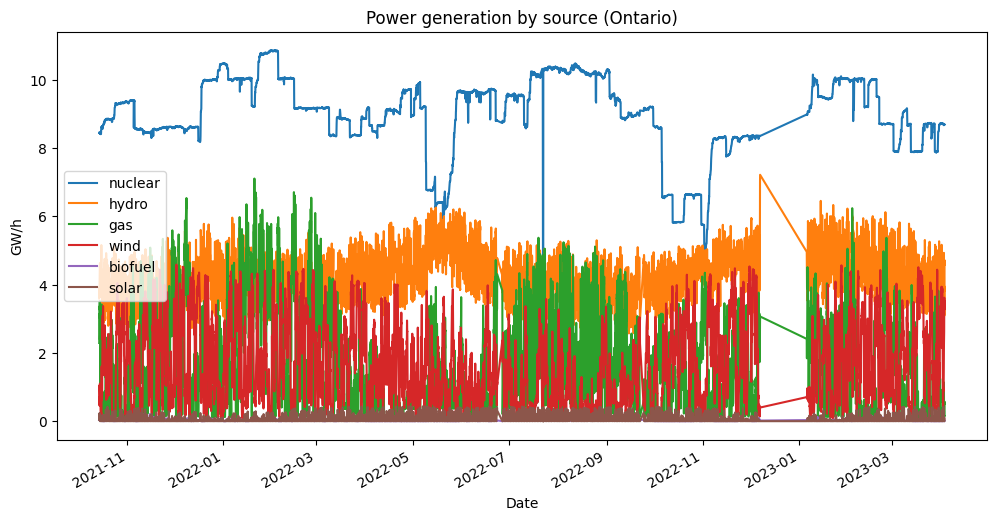

In [9]:
(df_summary[output_cols] / 1e3).plot()
plt.ylabel('GW/h')
plt.xlabel('Date')
plt.title('Power generation by source (Ontario)')
plt.legend([col.replace('Output', '') for col in output_cols])
plt.savefig(
    os.path.join("images", "power_generation_by_source.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

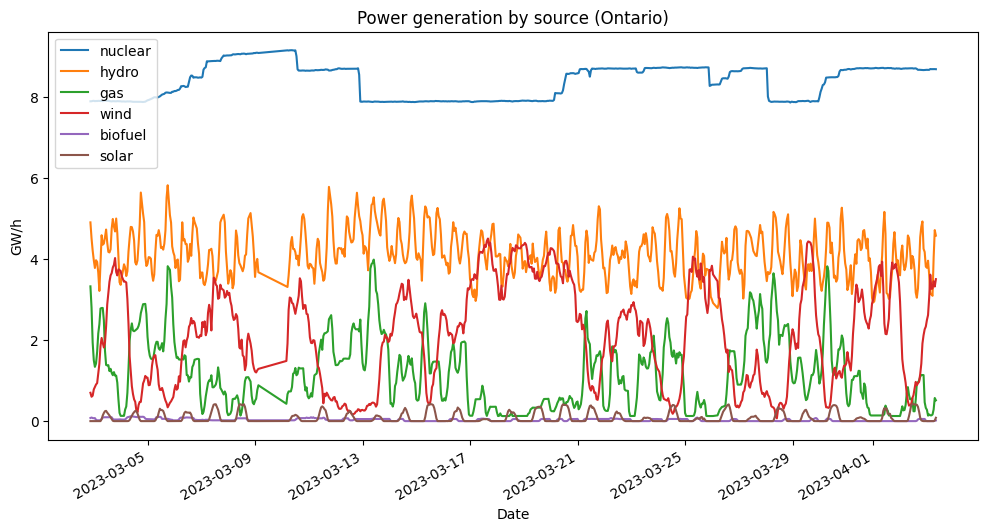

In [12]:
(df_summary[output_cols].iloc[-30*24:] / 1e3).plot()
plt.ylabel('GW/h')
plt.xlabel('Date')
plt.title('Power generation by source (Ontario)')
plt.legend([col.replace('Output', '') for col in output_cols])
plt.savefig(
    os.path.join("images", "power_generation_by_source.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

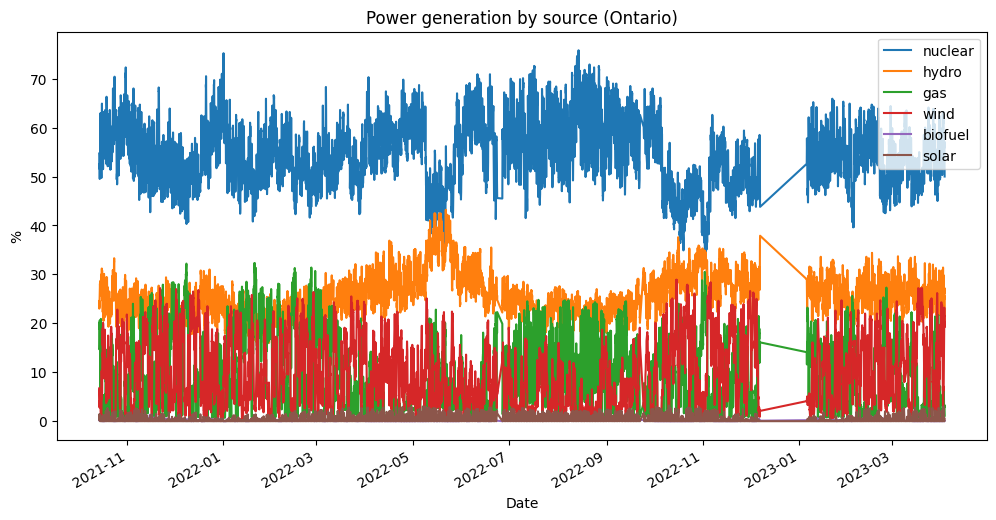

In [6]:
df_summary[percentage_cols].plot()
plt.ylabel('%')
plt.xlabel('Date')
plt.title('Power generation by source (Ontario)')
plt.legend([col.replace('Percentage', '') for col in percentage_cols])
plt.savefig(
    os.path.join("images", "power_generation_by_source_percentage.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

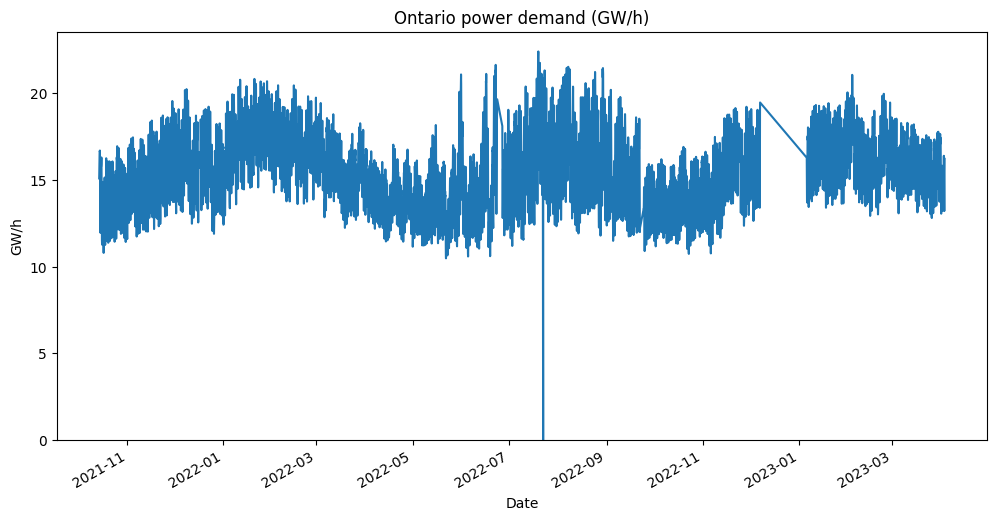

In [7]:
(df_summary['ONTARIO DEMAND'] / 1e3).plot()
plt.ylabel('GW/h')
plt.xlabel('Date')
plt.ylim([0, None])
plt.title('Ontario power demand (GW/h)')
plt.savefig(
    os.path.join("images", "power_demand.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

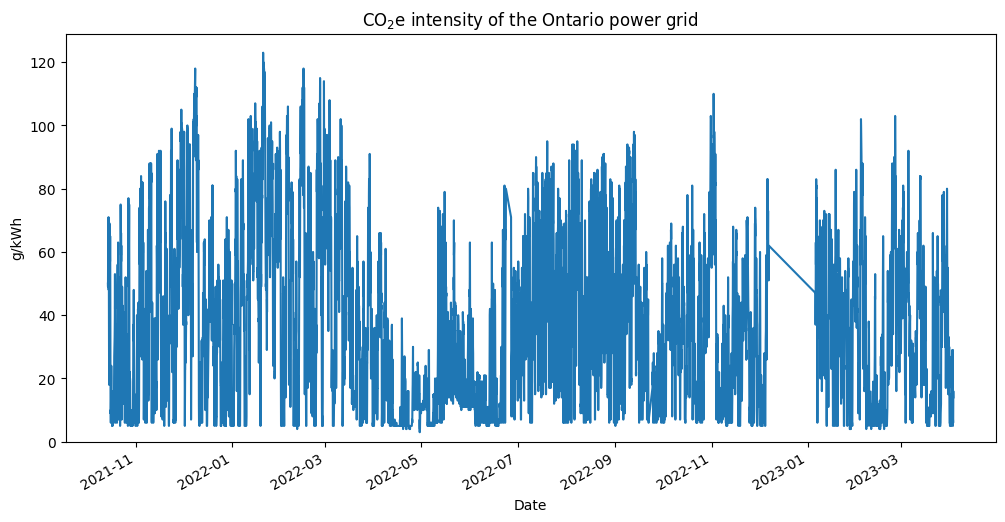

In [13]:
df_summary['CO2e INTENSITY'].plot()
plt.ylabel('g/kWh')
plt.xlabel('Date')
plt.ylim([0, None])
plt.title('CO$_2$e intensity of the Ontario power grid')
plt.savefig(
    os.path.join("images", "co2_intensity.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

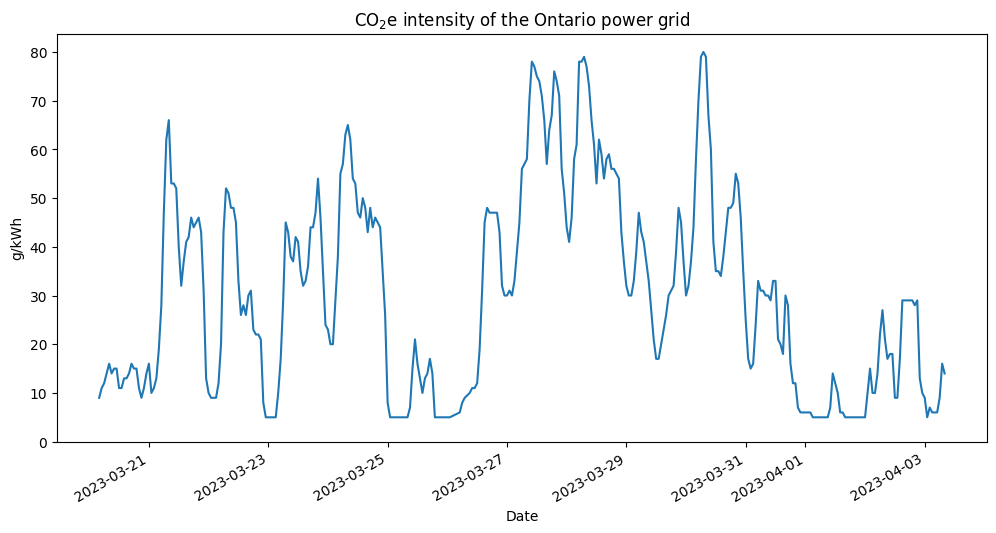

In [14]:
df_summary['CO2e INTENSITY'].iloc[-24*14:].plot()
plt.ylabel('g/kWh')
plt.xlabel('Date')
plt.ylim([0, None])
plt.title('CO$_2$e intensity of the Ontario power grid')
plt.savefig(
    os.path.join("images", "co2_intensity.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)